## Table of contents:
* [Set env](#set_env)
* [General information on Reactome biopax file](#general_reactome)
    * [Query 1: Number of elements for each biopax types](#query1)
* [Complexes](#complexes)
    * [Complexes in BioPAX specifications](#complexes_in_biopax)
    * [Complexes in Reactome](#complex_reactome)
        * [Summary](#summary)
        * [Query 2: How many black-box complexes?](#query2) 
        * [Query 3: How many complexes have at least one component? ](#query3)
        * [Query 4: How many complexes have at least one component that is a complex? ](#query4)
        * [Query 5: How many complexes have at least one component, none of which is a complex? ](#query5)
        * [Query 6: How many complexes have at least one component that is a blackbox complex ](#query6)
        * [Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? ](#query7)
        * [Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? ](#query8)
        * [Query 9: How many complexes, that are not black boxes, are a component of at least another complex? ](#query9)
        * [Query 10: Distribution of the number of direct components by complex ](#query10)  
        * [Query 11: Distribution of the number of complexes a complex is a component of](#query11)
        * [Query 12:  How many interactions directly involve an invalid complex? ?](#query12)
        * [Query 13: How many different components are involved in the invalid complexes?](#query13)
        * [Query 14: ??](#query14)
        * [Query 15: How many interactions directly involve a component of an invalid complex?](#query15)
        * [Query 16: How many interactions involve a complex having a direct component that is a component of an invalid complex?](#query16)
        * [Query 17: How many interactions directly and indirectly involve these components?](#query17)
        
    * [Identify the redundant complexes](#identify_redundant)
        * [Query 18: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular localisation?](#query18)
        * [How many cliques?](#cliques)
    * [Evaluation of the benefits for graph computing](#modules)
        * [Query 19: Depth of complex composition](#depth)

    * [Fix the invalid complexes](#fix_complexes)       
        
        

### Environment <a class="anchor" id="set_env"></a>

In [1]:
import importlib
import json
import matplotlib.pyplot as plt
import os
import pandas
import rdflib
import rdflib.namespace
import sparqldataframe
import seaborn as sns
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

import time
import jwt
import pathlib

import uri_utils
import complexComponents

In [2]:
reactomeVersion = 81
species = 48887
# species = 

endpointURL = "http://localhost:3030/REACTOME_HSAPIENS/query"
rdfFormat = "turtle"

workspace = "."
path_results = workspace+'/results-'+str(reactomeVersion)+'-'+str(species)
if not os.path.exists(path_results) :
  os.makedirs(path_results)

prefixesDict = uri_utils.readPrefixesFromFile("defaultPrefixes-release" + 
                                              str(reactomeVersion) + ".json")


In [3]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX chebi: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebidb: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX chebirel: <http://purl.obolibrary.org/obo/CHEBI#>

PREFIX up:<http://purl.uniprot.org/core/>
PREFIX udb: <http://purl.uniprot.org/database/>
PREFIX uniprot: <http://purl.uniprot.org/uniprot/>

PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX reactome: <http://www.reactome.org/biopax/""" + str(reactomeVersion)+"""/"""+str(species)+"""#>
"""

### General information on the dataset (Reactome Biopax Homo Sapiens v81) <a class="anchor" id="general_reactome"></a>

Query 1: Number of elements for each biopax types <a class="anchor" id="query1"></a>

In [4]:
## Reactome - initial file
## Version xml:base="http://www.reactome.org/biopax/81/48887#"> (2022-06)

## Number of elements for each biopax types
query="""
# Number of elements for each biopax types in reactome
SELECT ?type (COUNT(DISTINCT(?element)) AS ?nb_elements)
WHERE {
  ?element a ?type.
  FILTER(STRSTARTS(STR(?type),str(bp3:)) )
}
GROUP BY ?type
ORDER BY DESC (?nb_elements)
"""
pandas.set_option("max_colwidth", 80)
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,type,nb_elements
0,http://www.biopax.org/release/biopax-level3.owl#UnificationXref,164468
1,http://www.biopax.org/release/biopax-level3.owl#SequenceSite,63223
2,http://www.biopax.org/release/biopax-level3.owl#Stoichiometry,37244
3,http://www.biopax.org/release/biopax-level3.owl#PublicationXref,32189
4,http://www.biopax.org/release/biopax-level3.owl#Protein,31755
5,http://www.biopax.org/release/biopax-level3.owl#FragmentFeature,28383
6,http://www.biopax.org/release/biopax-level3.owl#SequenceInterval,28383
7,http://www.biopax.org/release/biopax-level3.owl#PathwayStep,16500
8,http://www.biopax.org/release/biopax-level3.owl#RelationshipXref,15495
9,http://www.biopax.org/release/biopax-level3.owl#Complex,14987


### Complexes <a class="anchor" id="complexes"></a>

#### Complexes in BioPAX specifications <a class="anchor" id="complexes_in_biopax"></a>

- **Complex** (BioPAX-level3 page 48)
    - physical product of an interaction
    - **complexes should not be defined recursively** (a complex should not be a component of another complex)
    - **exceptions are black box complexes** i.e. complexes in which the component property is empty
    - the `bp3:component` property
        - has domain: `bp3:Complex`
        - has range: `bp3:PhysicalEntity`, which subclasses are:
            - `bp3:Dna`
            - `bp3:Rna`
            - `bp3:Protein`
            - `bp3:Complex` warning: black box complexes only!
            - `bp3:SmallMolecule`
- **Black box complex**
- **Redundant complexes** are complexes having different identifiers, possibly from different databases but having the same chemical and physical properties
    - redundant complexes form equivalence classes

#### Complexes in Reactome <a class="anchor" id="complex_reactome"></a>
![](./2022_03_09_Complex_Biopax.png)

#### Summary <a class="anchor" id="summary"></a>
- complexes: 14840
- black box complexes: 858
- complexes that have at least one component: 13982
    - (complexes that are not black box complexes)
    - control: 14840-858=13982
    - they have up to 65 direct components
- complexes that have at least one component that is a complex: 6249
    - might be ok if all these components are black box complexes
    - 44.7% of 13982 
    - 42.1% of 14776 
    - control: complexes that have at least one component, none of which is a complex: 7733 (13982-6249=7733)
- complexes that have at least one component that is a black box complex: ~739~ 737
    - 11.8% of 6249 
- complexes that have at least one component that is a complex, and all its components that are complexes are actually black box complexes: ~517~ 515 
    - was expecting more, ideally 6249 
    - 8.2% of 6249 
- complexes that have at least one component that is a complex but not a black box complex: ~5710~ 5734
    - **these complexes should be fixed**
    - 38.6% of 14840
    - 41% of 13982
- complexes that are not black boxes but are a component of at least another complex: 4333
    - **they are the ones to look at for fixing the 5734**
    - they can be valid (i.e. all their components that are complexes are black box complexes) or invalid
    - they can be involved in chemical reactions (and therefore we should keep them, possibly after making them compliant and after detecting redundancies) or not (and these we can probably discard)
    -  ~1032~  of them are the direct component of more than one complex (max = direct component of 65 complexes)

Query 2: How many black-box complexes? <a class="anchor" id="query2"></a>

In [5]:
## OD
query="""
# Blackbox complexes

SELECT (COUNT(DISTINCT ?complexBB) AS ?nbComplexesBB)
WHERE {
  ?complexBB rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexBB bp3:component ?complexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexesBB
0,862


Query 3: How many complexes have at least one component? <a class="anchor" id="query3"></a>

In [6]:
## OD
query="""
# Complexes that have at least one component
# i.e. complexes that are not blackbox complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,14125


Query 4: How many complexes have at least one component that is a complex? <a class="anchor" id="query4"></a>

In [7]:
## OD
query="""
# Complexes that have at least one component that is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,6353


Query 5: How many complexes have at least one component, none of which is a complex? <a class="anchor" id="query5"></a>

In [8]:
## OD
query="""
# Complexes that have at least one component, none of which is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,7772


Query 6: How many complexes have at least one component that is a blackbox complex  <a class="anchor" id="query6"></a>

In [9]:
## OD
query="""
# Complexes that have at least one component that is a blackbox complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexComponent bp3:component ?someComplexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,748


Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? <a class="anchor" id="query7"></a>

In [10]:
## OD
query="""
# Complexes that have at least one component that is a complex, 
# and all its components that are complexes are actually black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
    ?someComplexComponent bp3:component ?someComplexComponentComponent .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,520


Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? <a class="anchor" id="query8"></a>

Number of invalid complexes

In [11]:
## OD
query="""
# All invalid complexes
# Complexes that have at least one component that is a complex, but not a black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  ?complexComponent bp3:component ?someComplexComponentComponent .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,5833


Query 9: How many complexes, that are not black-boxes, are a component of at least another complex? <a class="anchor" id="query9"></a>

In [12]:
## OD
query="""
# Complexes that are not black boxes but are a component of at least another complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  
  ?superComplex bp3:component ?complex .
  ?superComplex rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,4377


Query 10: Distribution of the number of direct components by complex <a class="anchor" id="query10"></a>

In [13]:
## OD
query="""
# Distribution of the number of direct components by complex

SELECT ?complex (COUNT(DISTINCT ?complexComponent) AS ?nbComponents)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?complex bp3:component ?complexComponent . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?complex bp3:component ?complexComponent . 
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbComponents"] = pandas.to_numeric(df["nbComponents"])
#df.to_csv("./direct_components.csv")
df["nbComponents"].describe()

count    14987.000000
mean         2.239274
std          2.609742
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         65.000000
Name: nbComponents, dtype: float64

In [14]:
df.to_csv('2022_09_19_r81_hsapiens_invalid_complexes_direct_comp.csv')  

Text(0.5, 0.98, 'Distribution of the number of direct components by complex')

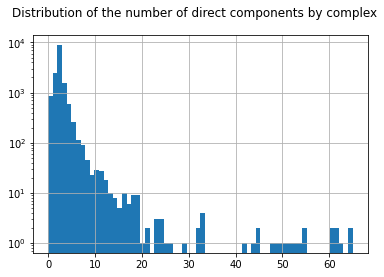

In [15]:
df['nbComponents'].hist(bins=df['nbComponents'].max()+1, log=True)
plt.suptitle("Distribution of the number of direct components by complex")

Query 11: Distribution of the number of complexes a complex is a component of<a class="anchor" id="query11"></a>

Text(0.5, 0.98, 'Distribution of the number of complexes a complex is a component of')

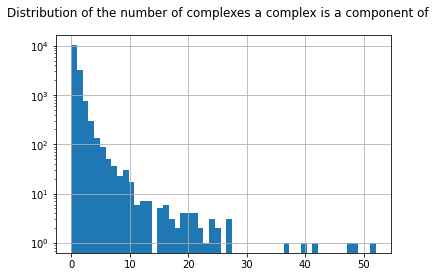

In [16]:
## OD
query="""
# Distribution of the number of complexes a complex is a component of

SELECT ?complex (COUNT(DISTINCT ?whole) AS ?nbWholes)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?whole bp3:component ?complex . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?whole bp3:component ?complex .
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbWholes"] = pandas.to_numeric(df["nbWholes"])
df["nbWholes"].describe()
df["nbWholes"].hist(bins=df['nbWholes'].max()+1, log=True)
plt.suptitle("Distribution of the number of complexes a complex is a component of")

Query 12: How many interactions **directly** involve invalid complexes? <a class="anchor" id="query12"></a>

In [17]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?interaction) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?rel rdfs:subPropertyOf* bp3:participant . 
  ?interaction ?rel ?invalidComplex .
  
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,7149


Query 13: How many different components (proteins, small molecules et physical entites) are involved in the invalid complexes? <a class="anchor" id="query13"></a>

In [18]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?leafComponent) AS ?nbInvalidComplexesComponents)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?someComplexComponentComponent .
  
  ?invalidComplex bp3:component+ ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInvalidComplexesComponents
0,7184


The 5,833 invalid complexes are (in)directly composed of 7,184 distinct entities that are not complexes, interactions, DNA or RNA. Nb: this excludes black-box complexes.

Query 14 : BioPAX types of interaction participants in Reactome <a class="anchor" id="query14"></a>

In [19]:
query = """ #type of participants
SELECT ?type (COUNT (DISTINCT ?participant) as ?nb_par)
WHERE {
  ?interaction rdf:type/rdfs:subClassOf* bp3:Interaction .
  ?rel rdfs:subPropertyOf* bp3:participant . 
  ?interaction ?rel ?participant .
  ?participant rdf:type ?type .
}
GROUP BY ?type
ORDER BY DESC(?nb_par)
"""
df = sparqldataframe.query(endpointURL, prefixes+query)
pandas.set_option("max_colwidth", 80)
df.to_csv("participants_type.csv")
df

,type,nb_par
0,http://www.biopax.org/release/biopax-level3.owl#Complex,10715
1,http://www.biopax.org/release/biopax-level3.owl#Protein,7709
2,http://www.biopax.org/release/biopax-level3.owl#BiochemicalReaction,7237
3,http://www.biopax.org/release/biopax-level3.owl#SmallMolecule,3008
4,http://www.biopax.org/release/biopax-level3.owl#PhysicalEntity,1249
5,http://www.biopax.org/release/biopax-level3.owl#Dna,679
6,http://www.biopax.org/release/biopax-level3.owl#Rna,166
7,http://www.biopax.org/release/biopax-level3.owl#Degradation,7
8,http://www.biopax.org/release/biopax-level3.owl#TemplateReaction,6


Query 15: How many interactions **directly** involve these components? <a class="anchor" id="query15"></a>

In [20]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#All interactions that have a participant that is a component of an invalid complex 

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .} 
  
  ?interact ?hasParticipant ?leafComponent .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,8038


Query 16: How many interactions involve a complex having a **direct** component that is a component of an invalid complex?  <a class="anchor" id="query16"></a>

Interactions involving a complex composed directly of a component of an invalid complex

In [21]:
query="""
# All interactions that have a participant that is a complex having a direct component that is a component of an invalid complex (excludes black-box complexes)

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  ?interactParticipant bp3:component? ?leafComponent . # 0 or 1 path
  ?interact ?hasParticipant ?interactParticipant .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,12454


Query 17: How many interactions **directly** and **indirectly** involve these components? <a class="anchor" id="query17"></a>

Interactions involving a complex (valid or invalid) composed indirectly of a component of an invalid complex or the component itself

In [22]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#Interactions involving a complex composed indirectly of a component of an invalid complex

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  
  ?interactParticipant bp3:component* ?leafComponent . # 0 or more paths
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .  
  ?interact ?hasParticipant ?interactParticipant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,13533


### Identify the redundant complexes <a class="anchor" id="identify_redundant"></a>

Query 18: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular location? <a class="anchor" id="query18"></a>

In [93]:
## OD CJ
query = """
# Retrieve redundant complexes i.e. pairs of complexes having different identifiers but the same components with the same stoichiometric coefficients
SELECT DISTINCT ?complex1  ?complex2 ?loc1# ?id1 ?id2 #?comp ?stoichioValue1 ?stoichioValue2

WHERE {
  #VALUES ?complex { reactome:Complex3 reactome:Complex7 reactome:Complex4 reactome:Complex5 reactome:Complex6 reactome:Complex8 reactome:Complex101 reactome:Complex102 }
  #VALUES ?complex { reactome:Complex102 }
  
  ?complex1 rdf:type bp3:Complex .
  # ?complex1 and ?complex2 have at least 1 common component (to avoid matching all the pairs of blackbox complexes that do not have any components)
  ?complex1 bp3:component ?commonComp .
  ?complex2 bp3:component ?commonComp .
  ?complex2 rdf:type bp3:Complex .
  ?complex1 bp3:cellularLocation ?loc1 .
  ?complex2 bp3:cellularLocation ?loc1 .
  FILTER (str(?complex1) < str(?complex2))
  
  # ?complex1 and ?complex2 do not have any common component that has different stoichiometric coefficients between the two complexes
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp .
    ?complex2 bp3:component ?comp .
    ?complex1 bp3:componentStoichiometry ?stoichio1 .
    ?stoichio1 bp3:physicalEntity ?comp .
    ?stoichio1 bp3:stoichiometricCoefficient ?stoichioValue1 .

    ?complex2 bp3:componentStoichiometry ?stoichio2 .
    ?stoichio2 bp3:physicalEntity ?comp .
    ?stoichio2 bp3:stoichiometricCoefficient ?stoichioValue2 .
    FILTER (?stoichioValue1 != ?stoichioValue2)
  }


  # all the direct components of ?complex1 are also components of ?complex2
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp1 .
    FILTER NOT EXISTS {
      ?complex2 bp3:component ?comp1 .
    }
  }
  # all the direct components of ?complex2 are also components of ?complex1
  FILTER NOT EXISTS {
    ?complex2 bp3:component ?comp2 .
    FILTER NOT EXISTS {
      ?complex1 bp3:component ?comp2 .
    }
  }
}
"""
df_redundant = sparqldataframe.query(endpointURL, prefixes+query)
df_redundant

,complex1,complex2,loc1
0,http://www.reactome.org/biopax/81/48887#Complex124,http://www.reactome.org/biopax/81/48887#Complex543,http://www.reactome.org/biopax/81/48887#CellularLocationVocabulary9
1,http://www.reactome.org/biopax/81/48887#Complex266,http://www.reactome.org/biopax/81/48887#Complex6701,http://www.reactome.org/biopax/81/48887#CellularLocationVocabulary11
2,http://www.reactome.org/biopax/81/48887#Complex403,http://www.reactome.org/biopax/81/48887#Complex9974,http://www.reactome.org/biopax/81/48887#CellularLocationVocabulary9
3,http://www.reactome.org/biopax/81/48887#Complex1028,http://www.reactome.org/biopax/81/48887#Complex1030,http://www.reactome.org/biopax/81/48887#CellularLocationVocabulary9
4,http://www.reactome.org/biopax/81/48887#Complex1533,http://www.reactome.org/biopax/81/48887#Complex4455,http://www.reactome.org/biopax/81/48887#CellularLocationVocabulary1
...,...,...,...
132,http://www.reactome.org/biopax/81/48887#Complex14688,http://www.reactome.org/biopax/81/48887#Complex14695,http://www.reactome.org/biopax/81/48887#CellularLocationVocabulary11
133,http://www.reactome.org/biopax/81/48887#Complex14850,http://www.reactome.org/biopax/81/48887#Complex7054,http://www.reactome.org/biopax/81/48887#CellularLocationVocabulary1
134,http://www.reactome.org/biopax/81/48887#Complex14866,http://www.reactome.org/biopax/81/48887#Complex1531,http://www.reactome.org/biopax/81/48887#CellularLocationVocabulary11
135,http://www.reactome.org/biopax/81/48887#Complex14880,http://www.reactome.org/biopax/81/48887#Complex3194,http://www.reactome.org/biopax/81/48887#CellularLocationVocabulary11


How many cliques? <a class="anchor" id="cliques"></a>

In [108]:
cliques = {df_redundant["complex1"][0] : [df_redundant["complex2"][0]]}
for row in df_redundant.itertuples(index=False):
    if row[0] in cliques :
        cliques[row[0]].append(row[1])
    elif row[1] in cliques :
        cliques[row[1]].append(row[0])
    else :
        found = False
        for i in cliques :
            if row[0] in cliques[i]:
                cliques[i].append(row[1])
                found = True
                break
            elif row[1] in cliques[i]:
                cliques[i].append(row[0])
                found = True
                break
        if not found :
            cliques[row[0]] = list()
            cliques[row[0]].append(row[1])
       
len(cliques) 

121

In [109]:
complexes = []
for c1 in df_redundant["complex1"] :
    complexes.append(c1)
for c2 in df_redundant["complex2"] :
    complexes.append(c2)
    
print(len(complexes))
print(len(set(complexes)))

274
249


###  Evaluation of the benefits for graph computing <a class="anchor" id="modules"></a>

Query 19: Depth of complex composition <a class="anchor" id="depth"></a>

In [24]:
queryListOfComplexes="""
# List of complexes

SELECT DISTINCT ?complex
WHERE {
  #?complex rdf:type/(rdfs:subClassOf*) bp3:Complex .
  ?complex rdf:type bp3:Complex .
}"""


def getComplexCompositionDepth(endpointURL, complexIdent):
    templateQueryNumberOfComponents = """
# Number of components

SELECT (COUNT(DISTINCT ?component) AS ?nbComponents)
WHERE {
  $physicalEntity$ bp3:component ?component .
}
"""
    sparqlWrapper = SPARQLWrapper(endpointURL)
    #print("!!!!! " + str(complexIdent.startswith("http")))
    #print(prefixes+templateQueryListOfComponents.replace("$physicalEntity$", "<" + complexIdent + ">" if complexIdent.startswith("http") else complexIdent))
    #print("!!!!!")
    sparqlWrapper.setQuery(prefixes+templateQueryNumberOfComponents.replace("$physicalEntity$", "<" + complexIdent + ">" if complexIdent.startswith("http") else complexIdent))
    sparqlWrapper.setReturnFormat(JSON)
    results = sparqlWrapper.query().convert()
    if int(results["results"]["bindings"][0]["nbComponents"]["value"]) == 0:
        return 0
    templateQueryListOfComplexComponents = """
# List of components

SELECT DISTINCT ?complexComponent
WHERE {
  $physicalEntity$ bp3:component ?complexComponent .
  ?complexComponent rdf:type bp3:Complex .
}
"""
    maxDepth = 0
    sparqlWrapper.setQuery(prefixes+templateQueryListOfComplexComponents.replace("$physicalEntity$", "<" + complexIdent + ">" if complexIdent.startswith("http") else complexIdent))
    sparqlWrapper.setReturnFormat(JSON)
    results = sparqlWrapper.query().convert()
    for result in results["results"]["bindings"]:
        complexComponentDepth = getComplexCompositionDepth(endpointURL, str(result["complexComponent"]["value"]))
        maxDepth = max(maxDepth, complexComponentDepth)
    return 1 + maxDepth
    

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+queryListOfComplexes)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
cpter = 0
complexesDepth = {}
for result in results["results"]["bindings"]:
    complexesDepth[result["complex"]["value"]] = {'depth': getComplexCompositionDepth(endpointURL, str(result["complex"]["value"]))}
    cpter += 1
    #if cpter > 9:
    #    break
df = pandas.DataFrame.from_dict(complexesDepth, orient='index')
df['depth'].describe()

count    14987.000000
mean         1.633949
std          1.187198
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         10.000000
Name: depth, dtype: float64

Text(0.5, 0.98, 'Distribution of the depth of complexes composition')

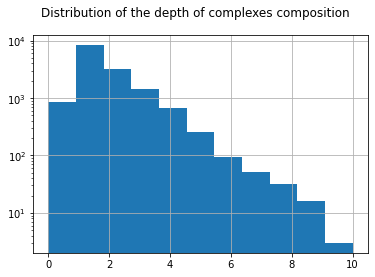

In [25]:
df["depth"].hist(bins=df['depth'].max()+1, log=True)
plt.suptitle("Distribution of the depth of complexes composition")

Text(0.5, 0.98, 'Distribution of the depth of complexes composition')

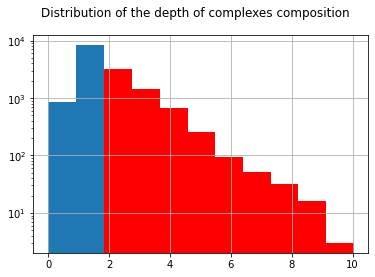

In [29]:
ax = df["depth"].hist(bins=df['depth'].max()+1, log=True)

for rect in ax.patches:
    if rect.get_x() > 1:
        rect.set_color('#FF0000')
plt.suptitle("Distribution of the depth of complexes composition")


In [26]:
# List of the deepest complexes

df.loc[df['depth']==10]

,depth
http://www.reactome.org/biopax/81/48887#Complex3240,10
http://www.reactome.org/biopax/81/48887#Complex8516,10
http://www.reactome.org/biopax/81/48887#Complex8594,10


In [27]:
df.to_csv('2022_09_19_r81_hsapiens_depth_complexes.csv')

* * *
### Fix the invalid complexes <a class="anchor" id="fix_complexes"></a>

- step 0: retrieve Reactome
       wget https://reactome.org/download/current/biopax.zip
       unzip biopax.zip Homo_sapiens.owl
       echo "Reactome version: $(expr "$(grep xml:base Homo_sapiens.owl)" : '.*http:\/\/www.reactome.org\/biopax\/\([[:digit:]]*\).*')"

- step 1: setup SPARQL endpoint with reactome
       # broken with fuseki-4.4.0: 
       # temporary fix
       ${FUSEKI_HOME}/fuseki-server --mem --update /reactome
       # then manually load Homo_sapiens.owl

- step 2: export the valid complexes

- step 3: export the fixed invalid complexes

- step 4: export reactome without complexes

- step 5: merge files 

![]("./Figure_drawio/2022_03_17_Stoichio.pdf")

Function 1: fix and export invalid complexes <a class="anchor" id="function1"></a>

In [23]:
def fixInvalidComplexes():
    ##### FIX INVALID COMPLEXES
    queryPath = 'queries/template-fixInvalidComplexes.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict)) 
#     sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    nbInvalidComplexes = len(results["results"]["bindings"])
    i = 0
    for result in results["results"]["bindings"]:
        print("{}\t{}\t{}".format(i, time.time()-startTime, result['invalidComplex']['value']))
        validGraph = rdflib.Graph()
        validGraph.bind("bp3","http://www.biopax.org/release/biopax-level3.owl#")
        complexComponents.getRepresentationBiopaxValid(endpointURL, result['invalidComplex']['value'], prefixesDict=prefixesDict, targetGraph=validGraph, rdfFormat="turtle", biopaxFilePath="")
        with open(path_results + "/reactome-v" + str(reactomeVersion) + '-' + str(species) + "-" + result['invalidComplex']['value'].replace("http://www.reactome.org/biopax/" + str(reactomeVersion) + "/" + str(species) + "#", "") + "-valid.ttl", 'w',encoding="utf-8") as rdfFile:
            rdfFile.write(validGraph.serialize(format=rdfFormat))#.decode('UTF-8'))
        i += 1
    
     #${JENA_HOME}/bin/riot --time --output=Turtle result/reactome-v81-Complex*.ttl > reactome-v81-complexes-invalid-fixed.ttl

Function 2: export valid complexes <a class="anchor" id="function2"></a>

In [26]:
def exportValidComplexes():
    ##### EXPORT VALID PART OF REACTOME
    queryPath = 'queries/template-extractValidComplexes-construct.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict)) 
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(rdfFormat)
    results = sparql.query().convert()
    validGraph = rdflib.Graph()
    validGraph.parse(data=results, format=rdfFormat)

    with open(path_results + "/reactome-v" + str(reactomeVersion) + '-' + str(species) + "-complexes-valid.ttl", 'w', encoding="utf-8") as rdfFile:
        rdfFile.write(validGraph.serialize(format=rdfFormat).encode().decode('UTF-8'))

Function 3: delete all complexes

In [110]:
def deleteAllComplexes():
    queryPath = 'queries/deleteOriginalComplexes.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict))
    print("Calling: " + endpointURL.replace("query", "update"))
    sparql = SPARQLWrapper(endpointURL.replace("query", "update"))
    sparql.setQuery(sparqlQuery)
    sparql.method = 'POST'
    #sparql.setReturnFormat(JSON)
    sparql.query()

In [8]:
validGraph = rdflib.Graph()
sparql = SPARQLWrapper(endpointURL)

In [24]:
startTime = time.time()
fixInvalidComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

0	0.24803709983825684	http://www.reactome.org/biopax/81/48887#Complex8
1	0.3511655330657959	http://www.reactome.org/biopax/81/48887#Complex9
2	0.5023634433746338	http://www.reactome.org/biopax/81/48887#Complex12
3	0.8064110279083252	http://www.reactome.org/biopax/81/48887#Complex14
4	1.0744919776916504	http://www.reactome.org/biopax/81/48887#Complex15
5	1.3391923904418945	http://www.reactome.org/biopax/81/48887#Complex17
6	1.6248748302459717	http://www.reactome.org/biopax/81/48887#Complex18
7	1.8889572620391846	http://www.reactome.org/biopax/81/48887#Complex20
8	2.0209388732910156	http://www.reactome.org/biopax/81/48887#Complex23
9	2.3701529502868652	http://www.reactome.org/biopax/81/48887#Complex24
10	2.525615692138672	http://www.reactome.org/biopax/81/48887#Complex26
11	2.806989908218384	http://www.reactome.org/biopax/81/48887#Complex27
12	2.9773318767547607	http://www.reactome.org/biopax/81/48887#Complex32
13	3.286663770675659	http://www.reactome.org/biopax/81/48887#Complex36
14	3.3

114	16.97977614402771	http://www.reactome.org/biopax/81/48887#Complex446
115	17.089203357696533	http://www.reactome.org/biopax/81/48887#Complex447
116	17.303149223327637	http://www.reactome.org/biopax/81/48887#Complex448
117	17.386258125305176	http://www.reactome.org/biopax/81/48887#Complex449
118	17.541491746902466	http://www.reactome.org/biopax/81/48887#Complex450
119	17.674513578414917	http://www.reactome.org/biopax/81/48887#Complex451
120	17.78450083732605	http://www.reactome.org/biopax/81/48887#Complex452
121	17.9185791015625	http://www.reactome.org/biopax/81/48887#Complex453
122	18.086689233779907	http://www.reactome.org/biopax/81/48887#Complex454
123	18.217529296875	http://www.reactome.org/biopax/81/48887#Complex455
124	18.34379744529724	http://www.reactome.org/biopax/81/48887#Complex456
125	18.546515703201294	http://www.reactome.org/biopax/81/48887#Complex457
126	18.649616956710815	http://www.reactome.org/biopax/81/48887#Complex458
127	18.746283054351807	http://www.reactome.org

229	32.93504619598389	http://www.reactome.org/biopax/81/48887#Complex750
230	33.01870083808899	http://www.reactome.org/biopax/81/48887#Complex751
231	33.126220703125	http://www.reactome.org/biopax/81/48887#Complex753
232	33.216410636901855	http://www.reactome.org/biopax/81/48887#Complex755
233	33.273845195770264	http://www.reactome.org/biopax/81/48887#Complex757
234	33.33247232437134	http://www.reactome.org/biopax/81/48887#Complex759
235	33.418009996414185	http://www.reactome.org/biopax/81/48887#Complex764
236	33.50355267524719	http://www.reactome.org/biopax/81/48887#Complex784
237	33.667624950408936	http://www.reactome.org/biopax/81/48887#Complex768
238	34.234370708465576	http://www.reactome.org/biopax/81/48887#Complex769
239	34.65241003036499	http://www.reactome.org/biopax/81/48887#Complex770
240	34.98606300354004	http://www.reactome.org/biopax/81/48887#Complex771
241	35.258711099624634	http://www.reactome.org/biopax/81/48887#Complex772
242	35.38002157211304	http://www.reactome.org/b

344	54.800087690353394	http://www.reactome.org/biopax/81/48887#Complex1694
345	54.89025092124939	http://www.reactome.org/biopax/81/48887#Complex1706
346	54.922646045684814	http://www.reactome.org/biopax/81/48887#Complex1702
347	54.97264862060547	http://www.reactome.org/biopax/81/48887#Complex1704
348	55.01311373710632	http://www.reactome.org/biopax/81/48887#Complex1716
349	55.1216504573822	http://www.reactome.org/biopax/81/48887#Complex1740
350	55.20120143890381	http://www.reactome.org/biopax/81/48887#Complex1743
351	55.80573272705078	http://www.reactome.org/biopax/81/48887#Complex1749
352	56.422974586486816	http://www.reactome.org/biopax/81/48887#Complex1745
353	56.4740936756134	http://www.reactome.org/biopax/81/48887#Complex1750
354	56.590938568115234	http://www.reactome.org/biopax/81/48887#Complex1751
355	57.42495656013489	http://www.reactome.org/biopax/81/48887#Complex1752
356	57.508498430252075	http://www.reactome.org/biopax/81/48887#Complex1753
357	57.55862307548523	http://www.re

455	136.50321531295776	http://www.reactome.org/biopax/81/48887#Complex1890
456	137.48760676383972	http://www.reactome.org/biopax/81/48887#Complex1891
457	139.9065659046173	http://www.reactome.org/biopax/81/48887#Complex1892
458	141.4914677143097	http://www.reactome.org/biopax/81/48887#Complex1893
459	143.09097337722778	http://www.reactome.org/biopax/81/48887#Complex1894
460	144.76036548614502	http://www.reactome.org/biopax/81/48887#Complex1895
461	146.44550275802612	http://www.reactome.org/biopax/81/48887#Complex1897
462	146.51329445838928	http://www.reactome.org/biopax/81/48887#Complex1898
463	146.62998914718628	http://www.reactome.org/biopax/81/48887#Complex1901
464	146.98006772994995	http://www.reactome.org/biopax/81/48887#Complex1902
465	148.39621567726135	http://www.reactome.org/biopax/81/48887#Complex1904
466	150.3668646812439	http://www.reactome.org/biopax/81/48887#Complex1905
467	150.66710472106934	http://www.reactome.org/biopax/81/48887#Complex1906
468	150.74864959716797	http:

565	184.74979543685913	http://www.reactome.org/biopax/81/48887#Complex2113
566	184.83431601524353	http://www.reactome.org/biopax/81/48887#Complex2115
567	184.97306394577026	http://www.reactome.org/biopax/81/48887#Complex2116
568	185.06045842170715	http://www.reactome.org/biopax/81/48887#Complex2118
569	185.1909441947937	http://www.reactome.org/biopax/81/48887#Complex2119
570	185.3298909664154	http://www.reactome.org/biopax/81/48887#Complex2122
571	185.47163724899292	http://www.reactome.org/biopax/81/48887#Complex2124
572	185.65164136886597	http://www.reactome.org/biopax/81/48887#Complex2125
573	185.74207639694214	http://www.reactome.org/biopax/81/48887#Complex2127
574	185.9215874671936	http://www.reactome.org/biopax/81/48887#Complex2128
575	186.17078614234924	http://www.reactome.org/biopax/81/48887#Complex2131
576	186.28927040100098	http://www.reactome.org/biopax/81/48887#Complex2133
577	186.44726252555847	http://www.reactome.org/biopax/81/48887#Complex2134
578	186.53698325157166	http:

675	202.41121912002563	http://www.reactome.org/biopax/81/48887#Complex2391
676	202.54266333580017	http://www.reactome.org/biopax/81/48887#Complex2393
677	202.735023021698	http://www.reactome.org/biopax/81/48887#Complex2401
678	202.84730195999146	http://www.reactome.org/biopax/81/48887#Complex2403
679	202.9362542629242	http://www.reactome.org/biopax/81/48887#Complex2410
680	203.18898797035217	http://www.reactome.org/biopax/81/48887#Complex2449
681	203.3357138633728	http://www.reactome.org/biopax/81/48887#Complex2450
682	203.43587732315063	http://www.reactome.org/biopax/81/48887#Complex2452
683	203.55495715141296	http://www.reactome.org/biopax/81/48887#Complex2463
684	206.60535883903503	http://www.reactome.org/biopax/81/48887#Complex2472
685	210.1421811580658	http://www.reactome.org/biopax/81/48887#Complex2467
686	212.77551341056824	http://www.reactome.org/biopax/81/48887#Complex2469
687	213.0624611377716	http://www.reactome.org/biopax/81/48887#Complex2476
688	216.71447849273682	http://w

785	255.88737630844116	http://www.reactome.org/biopax/81/48887#Complex2676
786	256.3868091106415	http://www.reactome.org/biopax/81/48887#Complex2677
787	256.8550887107849	http://www.reactome.org/biopax/81/48887#Complex2678
788	257.6259469985962	http://www.reactome.org/biopax/81/48887#Complex2679
789	258.1719346046448	http://www.reactome.org/biopax/81/48887#Complex2680
790	258.88497853279114	http://www.reactome.org/biopax/81/48887#Complex2681
791	259.71550965309143	http://www.reactome.org/biopax/81/48887#Complex2682
792	260.2101881504059	http://www.reactome.org/biopax/81/48887#Complex2683
793	260.84506130218506	http://www.reactome.org/biopax/81/48887#Complex2684
794	261.3427336215973	http://www.reactome.org/biopax/81/48887#Complex2685
795	262.0792570114136	http://www.reactome.org/biopax/81/48887#Complex2686
796	262.6773371696472	http://www.reactome.org/biopax/81/48887#Complex2687
797	263.2144956588745	http://www.reactome.org/biopax/81/48887#Complex2688
798	263.6930584907532	http://www.r

897	286.05618691444397	http://www.reactome.org/biopax/81/48887#Complex2934
898	286.2181558609009	http://www.reactome.org/biopax/81/48887#Complex2943
899	286.31742310523987	http://www.reactome.org/biopax/81/48887#Complex2946
900	286.4347198009491	http://www.reactome.org/biopax/81/48887#Complex2944
901	286.4865300655365	http://www.reactome.org/biopax/81/48887#Complex2948
902	286.54273319244385	http://www.reactome.org/biopax/81/48887#Complex2951
903	286.62361550331116	http://www.reactome.org/biopax/81/48887#Complex2953
904	286.67537212371826	http://www.reactome.org/biopax/81/48887#Complex2954
905	286.8043451309204	http://www.reactome.org/biopax/81/48887#Complex2955
906	286.90505862236023	http://www.reactome.org/biopax/81/48887#Complex2956
907	287.04858446121216	http://www.reactome.org/biopax/81/48887#Complex2959
908	287.3375144004822	http://www.reactome.org/biopax/81/48887#Complex2962
909	287.44230246543884	http://www.reactome.org/biopax/81/48887#Complex2965
910	287.52309131622314	http://

1008	304.368483543396	http://www.reactome.org/biopax/81/48887#Complex3186
1009	304.75411343574524	http://www.reactome.org/biopax/81/48887#Complex3188
1010	304.98701000213623	http://www.reactome.org/biopax/81/48887#Complex3191
1011	305.1087865829468	http://www.reactome.org/biopax/81/48887#Complex3192
1012	305.28528785705566	http://www.reactome.org/biopax/81/48887#Complex3194
1013	305.85115218162537	http://www.reactome.org/biopax/81/48887#Complex3196
1014	306.0735604763031	http://www.reactome.org/biopax/81/48887#Complex3197
1015	306.65365624427795	http://www.reactome.org/biopax/81/48887#Complex3198
1016	307.33788800239563	http://www.reactome.org/biopax/81/48887#Complex3199
1017	307.77442955970764	http://www.reactome.org/biopax/81/48887#Complex3200
1018	307.9381387233734	http://www.reactome.org/biopax/81/48887#Complex3201
1019	308.4509971141815	http://www.reactome.org/biopax/81/48887#Complex3206
1020	309.4806299209595	http://www.reactome.org/biopax/81/48887#Complex3202
1021	309.8404824733

1117	336.38108086586	http://www.reactome.org/biopax/81/48887#Complex3417
1118	336.45816135406494	http://www.reactome.org/biopax/81/48887#Complex3419
1119	336.55271887779236	http://www.reactome.org/biopax/81/48887#Complex3420
1120	336.6081392765045	http://www.reactome.org/biopax/81/48887#Complex3421
1121	336.6830937862396	http://www.reactome.org/biopax/81/48887#Complex3422
1122	336.79899525642395	http://www.reactome.org/biopax/81/48887#Complex3424
1123	336.92171573638916	http://www.reactome.org/biopax/81/48887#Complex3425
1124	337.0411949157715	http://www.reactome.org/biopax/81/48887#Complex3429
1125	337.1482162475586	http://www.reactome.org/biopax/81/48887#Complex3430
1126	337.2382333278656	http://www.reactome.org/biopax/81/48887#Complex3431
1127	337.30174493789673	http://www.reactome.org/biopax/81/48887#Complex3433
1128	337.36269307136536	http://www.reactome.org/biopax/81/48887#Complex3435
1129	337.4205148220062	http://www.reactome.org/biopax/81/48887#Complex3445
1130	337.485268592834

1226	353.9513204097748	http://www.reactome.org/biopax/81/48887#Complex3647
1227	354.0831182003021	http://www.reactome.org/biopax/81/48887#Complex3649
1228	354.1820046901703	http://www.reactome.org/biopax/81/48887#Complex3654
1229	354.50579738616943	http://www.reactome.org/biopax/81/48887#Complex3658
1230	354.68473529815674	http://www.reactome.org/biopax/81/48887#Complex3664
1231	354.7722496986389	http://www.reactome.org/biopax/81/48887#Complex3666
1232	354.87066864967346	http://www.reactome.org/biopax/81/48887#Complex3668
1233	354.95767879486084	http://www.reactome.org/biopax/81/48887#Complex3674
1234	355.0680913925171	http://www.reactome.org/biopax/81/48887#Complex3675
1235	355.2205264568329	http://www.reactome.org/biopax/81/48887#Complex3676
1236	355.32479596138	http://www.reactome.org/biopax/81/48887#Complex3677
1237	355.4108338356018	http://www.reactome.org/biopax/81/48887#Complex3678
1238	355.4941065311432	http://www.reactome.org/biopax/81/48887#Complex3679
1239	355.66703367233276

1335	370.38761925697327	http://www.reactome.org/biopax/81/48887#Complex3950
1336	370.49053597450256	http://www.reactome.org/biopax/81/48887#Complex3951
1337	370.6116762161255	http://www.reactome.org/biopax/81/48887#Complex3952
1338	370.7817134857178	http://www.reactome.org/biopax/81/48887#Complex3953
1339	371.19879961013794	http://www.reactome.org/biopax/81/48887#Complex3954
1340	371.39908361434937	http://www.reactome.org/biopax/81/48887#Complex3955
1341	371.6876413822174	http://www.reactome.org/biopax/81/48887#Complex3956
1342	371.8660910129547	http://www.reactome.org/biopax/81/48887#Complex3957
1343	371.9692780971527	http://www.reactome.org/biopax/81/48887#Complex3959
1344	372.068434715271	http://www.reactome.org/biopax/81/48887#Complex3961
1345	372.16979122161865	http://www.reactome.org/biopax/81/48887#Complex3962
1346	372.2509768009186	http://www.reactome.org/biopax/81/48887#Complex3963
1347	372.4354429244995	http://www.reactome.org/biopax/81/48887#Complex3964
1348	372.611008644104

1444	390.97800374031067	http://www.reactome.org/biopax/81/48887#Complex4105
1445	391.2213065624237	http://www.reactome.org/biopax/81/48887#Complex4106
1446	391.33933663368225	http://www.reactome.org/biopax/81/48887#Complex4118
1447	391.42434883117676	http://www.reactome.org/biopax/81/48887#Complex4121
1448	391.5047700405121	http://www.reactome.org/biopax/81/48887#Complex4122
1449	391.5931992530823	http://www.reactome.org/biopax/81/48887#Complex4124
1450	391.68780970573425	http://www.reactome.org/biopax/81/48887#Complex4125
1451	391.7948031425476	http://www.reactome.org/biopax/81/48887#Complex4126
1452	392.05479192733765	http://www.reactome.org/biopax/81/48887#Complex4127
1453	392.2049009799957	http://www.reactome.org/biopax/81/48887#Complex4128
1454	392.34540605545044	http://www.reactome.org/biopax/81/48887#Complex4130
1455	392.4791810512543	http://www.reactome.org/biopax/81/48887#Complex4134
1456	392.5578155517578	http://www.reactome.org/biopax/81/48887#Complex4135
1457	392.6220910549

1555	406.6892321109772	http://www.reactome.org/biopax/81/48887#Complex4310
1556	406.7616620063782	http://www.reactome.org/biopax/81/48887#Complex4313
1557	406.8438048362732	http://www.reactome.org/biopax/81/48887#Complex4314
1558	406.9202916622162	http://www.reactome.org/biopax/81/48887#Complex4315
1559	407.0186274051666	http://www.reactome.org/biopax/81/48887#Complex4316
1560	407.07828855514526	http://www.reactome.org/biopax/81/48887#Complex4317
1561	407.25291681289673	http://www.reactome.org/biopax/81/48887#Complex4318
1562	407.39157581329346	http://www.reactome.org/biopax/81/48887#Complex4319
1563	407.601389169693	http://www.reactome.org/biopax/81/48887#Complex4320
1564	407.7442729473114	http://www.reactome.org/biopax/81/48887#Complex4321
1565	407.941025018692	http://www.reactome.org/biopax/81/48887#Complex4322
1566	408.37302923202515	http://www.reactome.org/biopax/81/48887#Complex4323
1567	408.5579800605774	http://www.reactome.org/biopax/81/48887#Complex4324
1568	408.8211214542389	

1665	425.8410413265228	http://www.reactome.org/biopax/81/48887#Complex4470
1666	425.9564754962921	http://www.reactome.org/biopax/81/48887#Complex4473
1667	426.0414009094238	http://www.reactome.org/biopax/81/48887#Complex4471
1668	426.1041977405548	http://www.reactome.org/biopax/81/48887#Complex4474
1669	426.1626000404358	http://www.reactome.org/biopax/81/48887#Complex4477
1670	426.24280405044556	http://www.reactome.org/biopax/81/48887#Complex4478
1671	426.3294231891632	http://www.reactome.org/biopax/81/48887#Complex4482
1672	426.40520882606506	http://www.reactome.org/biopax/81/48887#Complex4483
1673	426.48659348487854	http://www.reactome.org/biopax/81/48887#Complex4484
1674	426.5639798641205	http://www.reactome.org/biopax/81/48887#Complex4486
1675	426.6408896446228	http://www.reactome.org/biopax/81/48887#Complex4487
1676	426.8744032382965	http://www.reactome.org/biopax/81/48887#Complex4497
1677	426.94821643829346	http://www.reactome.org/biopax/81/48887#Complex4498
1678	427.004954576492

1774	442.1039950847626	http://www.reactome.org/biopax/81/48887#Complex4700
1775	442.2033133506775	http://www.reactome.org/biopax/81/48887#Complex4702
1776	442.3053033351898	http://www.reactome.org/biopax/81/48887#Complex4704
1777	442.3928508758545	http://www.reactome.org/biopax/81/48887#Complex4705
1778	442.50609731674194	http://www.reactome.org/biopax/81/48887#Complex4710
1779	442.59155678749084	http://www.reactome.org/biopax/81/48887#Complex4717
1780	442.7280042171478	http://www.reactome.org/biopax/81/48887#Complex4719
1781	442.9740014076233	http://www.reactome.org/biopax/81/48887#Complex4720
1782	443.16365098953247	http://www.reactome.org/biopax/81/48887#Complex4721
1783	443.28878116607666	http://www.reactome.org/biopax/81/48887#Complex4722
1784	443.4052221775055	http://www.reactome.org/biopax/81/48887#Complex4724
1785	443.58870577812195	http://www.reactome.org/biopax/81/48887#Complex4725
1786	443.93980383872986	http://www.reactome.org/biopax/81/48887#Complex4726
1787	444.1550552845

1883	460.68791007995605	http://www.reactome.org/biopax/81/48887#Complex4893
1884	460.78232407569885	http://www.reactome.org/biopax/81/48887#Complex4896
1885	460.99115920066833	http://www.reactome.org/biopax/81/48887#Complex4897
1886	461.1883668899536	http://www.reactome.org/biopax/81/48887#Complex4903
1887	461.33935737609863	http://www.reactome.org/biopax/81/48887#Complex4905
1888	461.42393589019775	http://www.reactome.org/biopax/81/48887#Complex4906
1889	461.76174807548523	http://www.reactome.org/biopax/81/48887#Complex4907
1890	461.9380204677582	http://www.reactome.org/biopax/81/48887#Complex4908
1891	462.091356754303	http://www.reactome.org/biopax/81/48887#Complex4909
1892	462.24288868904114	http://www.reactome.org/biopax/81/48887#Complex4910
1893	462.32708263397217	http://www.reactome.org/biopax/81/48887#Complex4913
1894	462.50823998451233	http://www.reactome.org/biopax/81/48887#Complex4914
1895	462.7065279483795	http://www.reactome.org/biopax/81/48887#Complex4922
1896	462.78863430

1993	478.83909821510315	http://www.reactome.org/biopax/81/48887#Complex5102
1994	479.01083064079285	http://www.reactome.org/biopax/81/48887#Complex5103
1995	479.1227250099182	http://www.reactome.org/biopax/81/48887#Complex5104
1996	479.24504566192627	http://www.reactome.org/biopax/81/48887#Complex5105
1997	479.3597164154053	http://www.reactome.org/biopax/81/48887#Complex5107
1998	479.4954376220703	http://www.reactome.org/biopax/81/48887#Complex5108
1999	479.6302099227905	http://www.reactome.org/biopax/81/48887#Complex5113
2000	479.7175245285034	http://www.reactome.org/biopax/81/48887#Complex5115
2001	479.82228446006775	http://www.reactome.org/biopax/81/48887#Complex5117
2002	479.941921710968	http://www.reactome.org/biopax/81/48887#Complex5118
2003	480.0483763217926	http://www.reactome.org/biopax/81/48887#Complex5119
2004	480.4279696941376	http://www.reactome.org/biopax/81/48887#Complex5120
2005	480.5753412246704	http://www.reactome.org/biopax/81/48887#Complex5121
2006	480.6936304569244

2103	492.7416498661041	http://www.reactome.org/biopax/81/48887#Complex5290
2104	492.8557958602905	http://www.reactome.org/biopax/81/48887#Complex5291
2105	493.03790044784546	http://www.reactome.org/biopax/81/48887#Complex5292
2106	493.1653552055359	http://www.reactome.org/biopax/81/48887#Complex5295
2107	493.2363774776459	http://www.reactome.org/biopax/81/48887#Complex5296
2108	493.3375458717346	http://www.reactome.org/biopax/81/48887#Complex5297
2109	493.42516136169434	http://www.reactome.org/biopax/81/48887#Complex5298
2110	493.5073971748352	http://www.reactome.org/biopax/81/48887#Complex5299
2111	493.6071162223816	http://www.reactome.org/biopax/81/48887#Complex5300
2112	493.717059135437	http://www.reactome.org/biopax/81/48887#Complex5301
2113	493.80690741539	http://www.reactome.org/biopax/81/48887#Complex5302
2114	493.89620876312256	http://www.reactome.org/biopax/81/48887#Complex5303
2115	494.09277844429016	http://www.reactome.org/biopax/81/48887#Complex5305
2116	494.1801791191101	h

2212	513.625714302063	http://www.reactome.org/biopax/81/48887#Complex5594
2213	513.871114730835	http://www.reactome.org/biopax/81/48887#Complex5597
2214	514.0822341442108	http://www.reactome.org/biopax/81/48887#Complex5599
2215	514.2826044559479	http://www.reactome.org/biopax/81/48887#Complex5600
2216	514.6264479160309	http://www.reactome.org/biopax/81/48887#Complex5601
2217	514.8085663318634	http://www.reactome.org/biopax/81/48887#Complex5604
2218	514.9750907421112	http://www.reactome.org/biopax/81/48887#Complex5606
2219	515.1421246528625	http://www.reactome.org/biopax/81/48887#Complex5607
2220	515.3257057666779	http://www.reactome.org/biopax/81/48887#Complex5608
2221	515.4758372306824	http://www.reactome.org/biopax/81/48887#Complex5610
2222	515.6428918838501	http://www.reactome.org/biopax/81/48887#Complex5612
2223	515.7929978370667	http://www.reactome.org/biopax/81/48887#Complex5614
2224	515.9419786930084	http://www.reactome.org/biopax/81/48887#Complex5618
2225	516.0099668502808	http

2322	581.4778764247894	http://www.reactome.org/biopax/81/48887#Complex5854
2323	582.5184202194214	http://www.reactome.org/biopax/81/48887#Complex5855
2324	583.7092754840851	http://www.reactome.org/biopax/81/48887#Complex5856
2325	584.8103287220001	http://www.reactome.org/biopax/81/48887#Complex5863
2326	584.8812026977539	http://www.reactome.org/biopax/81/48887#Complex5866
2327	585.3952648639679	http://www.reactome.org/biopax/81/48887#Complex5867
2328	585.8604369163513	http://www.reactome.org/biopax/81/48887#Complex5873
2329	586.0282864570618	http://www.reactome.org/biopax/81/48887#Complex5874
2330	586.1640224456787	http://www.reactome.org/biopax/81/48887#Complex5878
2331	586.3619601726532	http://www.reactome.org/biopax/81/48887#Complex5879
2332	586.7113547325134	http://www.reactome.org/biopax/81/48887#Complex5883
2333	587.1751000881195	http://www.reactome.org/biopax/81/48887#Complex5884
2334	588.9800546169281	http://www.reactome.org/biopax/81/48887#Complex5885
2335	590.3165566921234	ht

2434	618.9734690189362	http://www.reactome.org/biopax/81/48887#Complex6107
2435	619.0475134849548	http://www.reactome.org/biopax/81/48887#Complex6109
2436	619.1197509765625	http://www.reactome.org/biopax/81/48887#Complex6111
2437	619.2467188835144	http://www.reactome.org/biopax/81/48887#Complex6112
2438	619.4109222888947	http://www.reactome.org/biopax/81/48887#Complex6113
2439	619.5480303764343	http://www.reactome.org/biopax/81/48887#Complex6118
2440	619.6112520694733	http://www.reactome.org/biopax/81/48887#Complex6120
2441	619.6961574554443	http://www.reactome.org/biopax/81/48887#Complex6121
2442	619.8053412437439	http://www.reactome.org/biopax/81/48887#Complex6124
2443	619.9949378967285	http://www.reactome.org/biopax/81/48887#Complex6125
2444	620.1607220172882	http://www.reactome.org/biopax/81/48887#Complex6130
2445	620.3431634902954	http://www.reactome.org/biopax/81/48887#Complex6132
2446	620.5626513957977	http://www.reactome.org/biopax/81/48887#Complex6141
2447	620.8294446468353	ht

2546	638.6364438533783	http://www.reactome.org/biopax/81/48887#Complex6310
2547	638.9739603996277	http://www.reactome.org/biopax/81/48887#Complex6311
2548	639.0476636886597	http://www.reactome.org/biopax/81/48887#Complex6312
2549	639.1876547336578	http://www.reactome.org/biopax/81/48887#Complex6313
2550	639.2991895675659	http://www.reactome.org/biopax/81/48887#Complex6314
2551	639.3971955776215	http://www.reactome.org/biopax/81/48887#Complex6315
2552	639.5030212402344	http://www.reactome.org/biopax/81/48887#Complex6316
2553	639.5853922367096	http://www.reactome.org/biopax/81/48887#Complex6317
2554	639.6955025196075	http://www.reactome.org/biopax/81/48887#Complex6320
2555	639.7789001464844	http://www.reactome.org/biopax/81/48887#Complex6321
2556	639.8504161834717	http://www.reactome.org/biopax/81/48887#Complex6323
2557	639.9305889606476	http://www.reactome.org/biopax/81/48887#Complex6324
2558	640.0047450065613	http://www.reactome.org/biopax/81/48887#Complex6327
2559	640.0840775966644	ht

2656	670.7821877002716	http://www.reactome.org/biopax/81/48887#Complex6598
2657	671.7690725326538	http://www.reactome.org/biopax/81/48887#Complex6600
2658	674.2313017845154	http://www.reactome.org/biopax/81/48887#Complex6601
2659	677.5356345176697	http://www.reactome.org/biopax/81/48887#Complex6602
2660	680.7052931785583	http://www.reactome.org/biopax/81/48887#Complex6603
2661	682.3939371109009	http://www.reactome.org/biopax/81/48887#Complex6604
2662	683.2724769115448	http://www.reactome.org/biopax/81/48887#Complex6605
2663	683.9574911594391	http://www.reactome.org/biopax/81/48887#Complex6606
2664	685.6894500255585	http://www.reactome.org/biopax/81/48887#Complex6607
2665	688.8299903869629	http://www.reactome.org/biopax/81/48887#Complex6608
2666	691.514803647995	http://www.reactome.org/biopax/81/48887#Complex6609
2667	694.6178617477417	http://www.reactome.org/biopax/81/48887#Complex6610
2668	697.6295156478882	http://www.reactome.org/biopax/81/48887#Complex6611
2669	698.8663079738617	htt

2767	788.1593008041382	http://www.reactome.org/biopax/81/48887#Complex6817
2768	788.3660564422607	http://www.reactome.org/biopax/81/48887#Complex6820
2769	788.6558105945587	http://www.reactome.org/biopax/81/48887#Complex6821
2770	788.9354469776154	http://www.reactome.org/biopax/81/48887#Complex6822
2771	789.1133761405945	http://www.reactome.org/biopax/81/48887#Complex6824
2772	789.357833147049	http://www.reactome.org/biopax/81/48887#Complex6825
2773	789.5942142009735	http://www.reactome.org/biopax/81/48887#Complex6826
2774	789.7610063552856	http://www.reactome.org/biopax/81/48887#Complex6827
2775	789.9434268474579	http://www.reactome.org/biopax/81/48887#Complex6829
2776	790.1622381210327	http://www.reactome.org/biopax/81/48887#Complex6831
2777	790.3801488876343	http://www.reactome.org/biopax/81/48887#Complex6839
2778	790.5618295669556	http://www.reactome.org/biopax/81/48887#Complex6847
2779	790.6463558673859	http://www.reactome.org/biopax/81/48887#Complex6849
2780	790.7127258777618	htt

2877	1060.726347208023	http://www.reactome.org/biopax/81/48887#Complex7041
2878	1061.0720908641815	http://www.reactome.org/biopax/81/48887#Complex7043
2879	1061.4737331867218	http://www.reactome.org/biopax/81/48887#Complex7046
2880	1061.5586915016174	http://www.reactome.org/biopax/81/48887#Complex7047
2881	1061.642703294754	http://www.reactome.org/biopax/81/48887#Complex7049
2882	1061.741732597351	http://www.reactome.org/biopax/81/48887#Complex7050
2883	1061.8372280597687	http://www.reactome.org/biopax/81/48887#Complex7051
2884	1062.0659232139587	http://www.reactome.org/biopax/81/48887#Complex7052
2885	1062.303659439087	http://www.reactome.org/biopax/81/48887#Complex7053
2886	1062.4080882072449	http://www.reactome.org/biopax/81/48887#Complex7100
2887	1062.5335557460785	http://www.reactome.org/biopax/81/48887#Complex7101
2888	1062.8419802188873	http://www.reactome.org/biopax/81/48887#Complex7107
2889	1062.9493782520294	http://www.reactome.org/biopax/81/48887#Complex7109
2890	1063.045028

2986	1095.9624030590057	http://www.reactome.org/biopax/81/48887#Complex7507
2987	1096.063570022583	http://www.reactome.org/biopax/81/48887#Complex7509
2988	1096.2752573490143	http://www.reactome.org/biopax/81/48887#Complex7510
2989	1096.4194362163544	http://www.reactome.org/biopax/81/48887#Complex7516
2990	1096.5618669986725	http://www.reactome.org/biopax/81/48887#Complex7519
2991	1096.9417638778687	http://www.reactome.org/biopax/81/48887#Complex7523
2992	1097.0433583259583	http://www.reactome.org/biopax/81/48887#Complex7525
2993	1097.1826915740967	http://www.reactome.org/biopax/81/48887#Complex7526
2994	1097.362956047058	http://www.reactome.org/biopax/81/48887#Complex7527
2995	1097.5108106136322	http://www.reactome.org/biopax/81/48887#Complex7536
2996	1097.6776313781738	http://www.reactome.org/biopax/81/48887#Complex7537
2997	1097.864854812622	http://www.reactome.org/biopax/81/48887#Complex7538
2998	1097.9965801239014	http://www.reactome.org/biopax/81/48887#Complex7539
2999	1098.19615

3095	1119.1834733486176	http://www.reactome.org/biopax/81/48887#Complex7885
3096	1119.2737596035004	http://www.reactome.org/biopax/81/48887#Complex7889
3097	1119.3836345672607	http://www.reactome.org/biopax/81/48887#Complex7890
3098	1119.4783418178558	http://www.reactome.org/biopax/81/48887#Complex7891
3099	1119.8825526237488	http://www.reactome.org/biopax/81/48887#Complex7892
3100	1120.143450498581	http://www.reactome.org/biopax/81/48887#Complex7893
3101	1120.2720067501068	http://www.reactome.org/biopax/81/48887#Complex7897
3102	1120.5655386447906	http://www.reactome.org/biopax/81/48887#Complex7899
3103	1120.766731262207	http://www.reactome.org/biopax/81/48887#Complex7904
3104	1120.9043962955475	http://www.reactome.org/biopax/81/48887#Complex7908
3105	1121.0165719985962	http://www.reactome.org/biopax/81/48887#Complex7909
3106	1121.1073005199432	http://www.reactome.org/biopax/81/48887#Complex7910
3107	1121.28417801857	http://www.reactome.org/biopax/81/48887#Complex7917
3108	1121.383332

3204	1362.7223451137543	http://www.reactome.org/biopax/81/48887#Complex8157
3205	1378.2336730957031	http://www.reactome.org/biopax/81/48887#Complex8158
3206	1378.6868410110474	http://www.reactome.org/biopax/81/48887#Complex8159
3207	1388.9299154281616	http://www.reactome.org/biopax/81/48887#Complex8161
3208	1398.5171866416931	http://www.reactome.org/biopax/81/48887#Complex8160
3209	1398.6623249053955	http://www.reactome.org/biopax/81/48887#Complex8162
3210	1401.8156125545502	http://www.reactome.org/biopax/81/48887#Complex8170
3211	1404.843990802765	http://www.reactome.org/biopax/81/48887#Complex8163
3212	1408.0105493068695	http://www.reactome.org/biopax/81/48887#Complex8171
3213	1411.3195865154266	http://www.reactome.org/biopax/81/48887#Complex8172
3214	1415.2368259429932	http://www.reactome.org/biopax/81/48887#Complex8173
3215	1419.6455454826355	http://www.reactome.org/biopax/81/48887#Complex8174
3216	1420.1682262420654	http://www.reactome.org/biopax/81/48887#Complex8178
3217	1420.625

3313	1458.6482651233673	http://www.reactome.org/biopax/81/48887#Complex8446
3314	1458.8869233131409	http://www.reactome.org/biopax/81/48887#Complex8447
3315	1459.435231924057	http://www.reactome.org/biopax/81/48887#Complex8448
3316	1459.7456555366516	http://www.reactome.org/biopax/81/48887#Complex8449
3317	1460.445373058319	http://www.reactome.org/biopax/81/48887#Complex8452
3318	1460.5719501972198	http://www.reactome.org/biopax/81/48887#Complex8455
3319	1460.697925567627	http://www.reactome.org/biopax/81/48887#Complex8456
3320	1460.852102279663	http://www.reactome.org/biopax/81/48887#Complex8457
3321	1460.9767434597015	http://www.reactome.org/biopax/81/48887#Complex8458
3322	1461.261430978775	http://www.reactome.org/biopax/81/48887#Complex8461
3323	1461.5043075084686	http://www.reactome.org/biopax/81/48887#Complex8462
3324	1462.0490760803223	http://www.reactome.org/biopax/81/48887#Complex8463
3325	1462.6757698059082	http://www.reactome.org/biopax/81/48887#Complex8469
3326	1463.1281900

3422	1521.4856429100037	http://www.reactome.org/biopax/81/48887#Complex8600
3423	1521.6391983032227	http://www.reactome.org/biopax/81/48887#Complex8602
3424	1522.021047592163	http://www.reactome.org/biopax/81/48887#Complex8603
3425	1522.3542878627777	http://www.reactome.org/biopax/81/48887#Complex8605
3426	1522.8333613872528	http://www.reactome.org/biopax/81/48887#Complex8608
3427	1523.0777335166931	http://www.reactome.org/biopax/81/48887#Complex8606
3428	1523.1873178482056	http://www.reactome.org/biopax/81/48887#Complex8609
3429	1523.4640045166016	http://www.reactome.org/biopax/81/48887#Complex8610
3430	1523.5868301391602	http://www.reactome.org/biopax/81/48887#Complex8612
3431	1524.075189590454	http://www.reactome.org/biopax/81/48887#Complex8613
3432	1524.4037601947784	http://www.reactome.org/biopax/81/48887#Complex8614
3433	1524.7943024635315	http://www.reactome.org/biopax/81/48887#Complex8615
3434	1524.9517345428467	http://www.reactome.org/biopax/81/48887#Complex8617
3435	1526.1351

3532	1611.576492547989	http://www.reactome.org/biopax/81/48887#Complex8950
3533	1611.7901408672333	http://www.reactome.org/biopax/81/48887#Complex8964
3534	1611.846245765686	http://www.reactome.org/biopax/81/48887#Complex8967
3535	1611.9288568496704	http://www.reactome.org/biopax/81/48887#Complex8981
3536	1612.0052194595337	http://www.reactome.org/biopax/81/48887#Complex8983
3537	1612.0921919345856	http://www.reactome.org/biopax/81/48887#Complex8984
3538	1612.328441143036	http://www.reactome.org/biopax/81/48887#Complex8998
3539	1612.4433104991913	http://www.reactome.org/biopax/81/48887#Complex9012
3540	1612.5104115009308	http://www.reactome.org/biopax/81/48887#Complex9075
3541	1612.6077330112457	http://www.reactome.org/biopax/81/48887#Complex9109
3542	1612.6808807849884	http://www.reactome.org/biopax/81/48887#Complex9114
3543	1612.8421573638916	http://www.reactome.org/biopax/81/48887#Complex9120
3544	1612.9245946407318	http://www.reactome.org/biopax/81/48887#Complex9122
3545	1613.02573

3641	1637.2742159366608	http://www.reactome.org/biopax/81/48887#Complex9398
3642	1640.861645936966	http://www.reactome.org/biopax/81/48887#Complex9399
3643	1641.1944584846497	http://www.reactome.org/biopax/81/48887#Complex9400
3644	1645.7760586738586	http://www.reactome.org/biopax/81/48887#Complex9401
3645	1649.0128245353699	http://www.reactome.org/biopax/81/48887#Complex9402
3646	1651.6450893878937	http://www.reactome.org/biopax/81/48887#Complex9408
3647	1651.9859964847565	http://www.reactome.org/biopax/81/48887#Complex9403
3648	1654.3727748394012	http://www.reactome.org/biopax/81/48887#Complex9404
3649	1654.5756287574768	http://www.reactome.org/biopax/81/48887#Complex9405
3650	1656.0044059753418	http://www.reactome.org/biopax/81/48887#Complex9406
3651	1657.9188024997711	http://www.reactome.org/biopax/81/48887#Complex9407
3652	1658.1358678340912	http://www.reactome.org/biopax/81/48887#Complex9409
3653	1658.3389251232147	http://www.reactome.org/biopax/81/48887#Complex9413
3654	1658.801

3750	1692.037418603897	http://www.reactome.org/biopax/81/48887#Complex9956
3751	1692.144362449646	http://www.reactome.org/biopax/81/48887#Complex9958
3752	1692.2837057113647	http://www.reactome.org/biopax/81/48887#Complex9961
3753	1692.3623621463776	http://www.reactome.org/biopax/81/48887#Complex9962
3754	1692.640810251236	http://www.reactome.org/biopax/81/48887#Complex9963
3755	1692.839643239975	http://www.reactome.org/biopax/81/48887#Complex9964
3756	1693.2186686992645	http://www.reactome.org/biopax/81/48887#Complex9965
3757	1693.4615898132324	http://www.reactome.org/biopax/81/48887#Complex9966
3758	1693.653252363205	http://www.reactome.org/biopax/81/48887#Complex9967
3759	1694.0277061462402	http://www.reactome.org/biopax/81/48887#Complex9968
3760	1694.1589512825012	http://www.reactome.org/biopax/81/48887#Complex9969
3761	1694.4461724758148	http://www.reactome.org/biopax/81/48887#Complex9970
3762	1694.5033266544342	http://www.reactome.org/biopax/81/48887#Complex9972
3763	1694.8389730

3857	1710.6846044063568	http://www.reactome.org/biopax/81/48887#Complex10196
3858	1710.7593700885773	http://www.reactome.org/biopax/81/48887#Complex10197
3859	1710.815978527069	http://www.reactome.org/biopax/81/48887#Complex10201
3860	1711.092989206314	http://www.reactome.org/biopax/81/48887#Complex10204
3861	1711.3316731452942	http://www.reactome.org/biopax/81/48887#Complex10207
3862	1711.4776604175568	http://www.reactome.org/biopax/81/48887#Complex10208
3863	1711.5693175792694	http://www.reactome.org/biopax/81/48887#Complex10211
3864	1711.670536994934	http://www.reactome.org/biopax/81/48887#Complex10212
3865	1711.7835175991058	http://www.reactome.org/biopax/81/48887#Complex10213
3866	1711.9541959762573	http://www.reactome.org/biopax/81/48887#Complex10214
3867	1712.0912532806396	http://www.reactome.org/biopax/81/48887#Complex10215
3868	1712.2132413387299	http://www.reactome.org/biopax/81/48887#Complex10217
3869	1712.3395733833313	http://www.reactome.org/biopax/81/48887#Complex10218
38

3964	1726.5721054077148	http://www.reactome.org/biopax/81/48887#Complex10392
3965	1726.7728774547577	http://www.reactome.org/biopax/81/48887#Complex10393
3966	1726.9974875450134	http://www.reactome.org/biopax/81/48887#Complex10394
3967	1727.1600818634033	http://www.reactome.org/biopax/81/48887#Complex10395
3968	1727.338849067688	http://www.reactome.org/biopax/81/48887#Complex10396
3969	1727.5445368289948	http://www.reactome.org/biopax/81/48887#Complex10399
3970	1727.8091802597046	http://www.reactome.org/biopax/81/48887#Complex10400
3971	1728.0448632240295	http://www.reactome.org/biopax/81/48887#Complex10401
3972	1728.3330557346344	http://www.reactome.org/biopax/81/48887#Complex10402
3973	1728.448031425476	http://www.reactome.org/biopax/81/48887#Complex10404
3974	1728.7072248458862	http://www.reactome.org/biopax/81/48887#Complex10405
3975	1728.8323419094086	http://www.reactome.org/biopax/81/48887#Complex10408
3976	1728.9306910037994	http://www.reactome.org/biopax/81/48887#Complex10409
3

4072	1740.3082418441772	http://www.reactome.org/biopax/81/48887#Complex10596
4073	1740.631058216095	http://www.reactome.org/biopax/81/48887#Complex10597
4074	1740.7405498027802	http://www.reactome.org/biopax/81/48887#Complex10598
4075	1740.8750410079956	http://www.reactome.org/biopax/81/48887#Complex10599
4076	1741.0145053863525	http://www.reactome.org/biopax/81/48887#Complex10600
4077	1741.1368083953857	http://www.reactome.org/biopax/81/48887#Complex10601
4078	1741.2595434188843	http://www.reactome.org/biopax/81/48887#Complex10602
4079	1741.4672021865845	http://www.reactome.org/biopax/81/48887#Complex10603
4080	1741.597906589508	http://www.reactome.org/biopax/81/48887#Complex10604
4081	1741.7984211444855	http://www.reactome.org/biopax/81/48887#Complex10607
4082	1741.9930856227875	http://www.reactome.org/biopax/81/48887#Complex10626
4083	1742.1209962368011	http://www.reactome.org/biopax/81/48887#Complex10627
4084	1742.3164947032928	http://www.reactome.org/biopax/81/48887#Complex10628
4

4180	1756.4733123779297	http://www.reactome.org/biopax/81/48887#Complex10995
4181	1756.684844493866	http://www.reactome.org/biopax/81/48887#Complex10996
4182	1756.8104462623596	http://www.reactome.org/biopax/81/48887#Complex10997
4183	1757.001976966858	http://www.reactome.org/biopax/81/48887#Complex11000
4184	1757.1834616661072	http://www.reactome.org/biopax/81/48887#Complex10998
4185	1757.4674363136292	http://www.reactome.org/biopax/81/48887#Complex11001
4186	1757.6088299751282	http://www.reactome.org/biopax/81/48887#Complex11003
4187	1757.7087919712067	http://www.reactome.org/biopax/81/48887#Complex11004
4188	1757.8078343868256	http://www.reactome.org/biopax/81/48887#Complex11005
4189	1757.906830072403	http://www.reactome.org/biopax/81/48887#Complex11008
4190	1758.048909187317	http://www.reactome.org/biopax/81/48887#Complex11010
4191	1758.226719379425	http://www.reactome.org/biopax/81/48887#Complex11011
4192	1758.4016330242157	http://www.reactome.org/biopax/81/48887#Complex11013
4193

4288	1773.006031036377	http://www.reactome.org/biopax/81/48887#Complex11232
4289	1773.3218820095062	http://www.reactome.org/biopax/81/48887#Complex11233
4290	1773.4163990020752	http://www.reactome.org/biopax/81/48887#Complex11234
4291	1773.515341758728	http://www.reactome.org/biopax/81/48887#Complex11235
4292	1773.6242334842682	http://www.reactome.org/biopax/81/48887#Complex11236
4293	1773.7387204170227	http://www.reactome.org/biopax/81/48887#Complex11239
4294	1773.918377161026	http://www.reactome.org/biopax/81/48887#Complex11240
4295	1774.043045282364	http://www.reactome.org/biopax/81/48887#Complex11241
4296	1774.1538701057434	http://www.reactome.org/biopax/81/48887#Complex11242
4297	1774.2500026226044	http://www.reactome.org/biopax/81/48887#Complex11248
4298	1774.3764653205872	http://www.reactome.org/biopax/81/48887#Complex11250
4299	1774.5075600147247	http://www.reactome.org/biopax/81/48887#Complex11253
4300	1774.6285758018494	http://www.reactome.org/biopax/81/48887#Complex11254
430

4397	1790.0922288894653	http://www.reactome.org/biopax/81/48887#Complex11522
4398	1790.2016105651855	http://www.reactome.org/biopax/81/48887#Complex11523
4399	1790.2896192073822	http://www.reactome.org/biopax/81/48887#Complex11533
4400	1790.4079051017761	http://www.reactome.org/biopax/81/48887#Complex11534
4401	1790.8097381591797	http://www.reactome.org/biopax/81/48887#Complex11535
4402	1790.9357869625092	http://www.reactome.org/biopax/81/48887#Complex11536
4403	1791.056969165802	http://www.reactome.org/biopax/81/48887#Complex11537
4404	1791.1389434337616	http://www.reactome.org/biopax/81/48887#Complex11539
4405	1791.2798669338226	http://www.reactome.org/biopax/81/48887#Complex11540
4406	1791.4443607330322	http://www.reactome.org/biopax/81/48887#Complex11541
4407	1791.542456150055	http://www.reactome.org/biopax/81/48887#Complex11542
4408	1791.7035019397736	http://www.reactome.org/biopax/81/48887#Complex11543
4409	1791.8195490837097	http://www.reactome.org/biopax/81/48887#Complex11544
4

4505	1816.3383114337921	http://www.reactome.org/biopax/81/48887#Complex11689
4506	1816.4723761081696	http://www.reactome.org/biopax/81/48887#Complex11691
4507	1816.5507485866547	http://www.reactome.org/biopax/81/48887#Complex11692
4508	1816.6384720802307	http://www.reactome.org/biopax/81/48887#Complex11693
4509	1816.863926410675	http://www.reactome.org/biopax/81/48887#Complex11697
4510	1817.068725347519	http://www.reactome.org/biopax/81/48887#Complex11699
4511	1817.1990282535553	http://www.reactome.org/biopax/81/48887#Complex11700
4512	1817.3594057559967	http://www.reactome.org/biopax/81/48887#Complex11703
4513	1817.527606010437	http://www.reactome.org/biopax/81/48887#Complex11705
4514	1817.6552307605743	http://www.reactome.org/biopax/81/48887#Complex11708
4515	1817.7732470035553	http://www.reactome.org/biopax/81/48887#Complex11710
4516	1817.8797883987427	http://www.reactome.org/biopax/81/48887#Complex11714
4517	1818.0072755813599	http://www.reactome.org/biopax/81/48887#Complex11716
45

4614	1832.2429213523865	http://www.reactome.org/biopax/81/48887#Complex12009
4615	1832.3320026397705	http://www.reactome.org/biopax/81/48887#Complex12011
4616	1832.4107868671417	http://www.reactome.org/biopax/81/48887#Complex12015
4617	1832.5087747573853	http://www.reactome.org/biopax/81/48887#Complex12017
4618	1832.5993957519531	http://www.reactome.org/biopax/81/48887#Complex12021
4619	1832.688276052475	http://www.reactome.org/biopax/81/48887#Complex12025
4620	1832.7806162834167	http://www.reactome.org/biopax/81/48887#Complex12027
4621	1832.8418810367584	http://www.reactome.org/biopax/81/48887#Complex12030
4622	1832.9552927017212	http://www.reactome.org/biopax/81/48887#Complex12033
4623	1833.0481741428375	http://www.reactome.org/biopax/81/48887#Complex12038
4624	1833.1471767425537	http://www.reactome.org/biopax/81/48887#Complex12041
4625	1833.2562222480774	http://www.reactome.org/biopax/81/48887#Complex12044
4626	1833.39954662323	http://www.reactome.org/biopax/81/48887#Complex12046
46

4721	1880.3589844703674	http://www.reactome.org/biopax/81/48887#Complex12221
4722	1880.8210589885712	http://www.reactome.org/biopax/81/48887#Complex12222
4723	1881.3138802051544	http://www.reactome.org/biopax/81/48887#Complex12223
4724	1881.9682281017303	http://www.reactome.org/biopax/81/48887#Complex12224
4725	1882.5338387489319	http://www.reactome.org/biopax/81/48887#Complex12225
4726	1883.1681509017944	http://www.reactome.org/biopax/81/48887#Complex12226
4727	1883.536294221878	http://www.reactome.org/biopax/81/48887#Complex12229
4728	1883.6593687534332	http://www.reactome.org/biopax/81/48887#Complex12233
4729	1883.7176492214203	http://www.reactome.org/biopax/81/48887#Complex12234
4730	1883.7874059677124	http://www.reactome.org/biopax/81/48887#Complex12237
4731	1883.9208598136902	http://www.reactome.org/biopax/81/48887#Complex12240
4732	1884.1283626556396	http://www.reactome.org/biopax/81/48887#Complex12241
4733	1884.4117085933685	http://www.reactome.org/biopax/81/48887#Complex12242


4829	1901.111269235611	http://www.reactome.org/biopax/81/48887#Complex12393
4830	1901.2509977817535	http://www.reactome.org/biopax/81/48887#Complex12394
4831	1901.4787719249725	http://www.reactome.org/biopax/81/48887#Complex12396
4832	1901.702843427658	http://www.reactome.org/biopax/81/48887#Complex12397
4833	1902.1273741722107	http://www.reactome.org/biopax/81/48887#Complex12409
4834	1902.2375586032867	http://www.reactome.org/biopax/81/48887#Complex12410
4835	1902.303153038025	http://www.reactome.org/biopax/81/48887#Complex12413
4836	1902.3702166080475	http://www.reactome.org/biopax/81/48887#Complex12414
4837	1902.6667640209198	http://www.reactome.org/biopax/81/48887#Complex12431
4838	1902.7801287174225	http://www.reactome.org/biopax/81/48887#Complex12434
4839	1902.988354921341	http://www.reactome.org/biopax/81/48887#Complex12437
4840	1903.0435292720795	http://www.reactome.org/biopax/81/48887#Complex12438
4841	1903.140424489975	http://www.reactome.org/biopax/81/48887#Complex12439
4842

4936	1915.589560508728	http://www.reactome.org/biopax/81/48887#Complex12750
4937	1915.6852083206177	http://www.reactome.org/biopax/81/48887#Complex12753
4938	1915.7774386405945	http://www.reactome.org/biopax/81/48887#Complex12757
4939	1915.864443063736	http://www.reactome.org/biopax/81/48887#Complex12759
4940	1915.9576621055603	http://www.reactome.org/biopax/81/48887#Complex12767
4941	1916.1864383220673	http://www.reactome.org/biopax/81/48887#Complex12771
4942	1916.4031519889832	http://www.reactome.org/biopax/81/48887#Complex12769
4943	1916.4684946537018	http://www.reactome.org/biopax/81/48887#Complex12773
4944	1916.7203612327576	http://www.reactome.org/biopax/81/48887#Complex12780
4945	1916.955825805664	http://www.reactome.org/biopax/81/48887#Complex12781
4946	1917.2125344276428	http://www.reactome.org/biopax/81/48887#Complex12782
4947	1917.6649179458618	http://www.reactome.org/biopax/81/48887#Complex12784
4948	1917.832321882248	http://www.reactome.org/biopax/81/48887#Complex12786
494

5044	1940.752469778061	http://www.reactome.org/biopax/81/48887#Complex12989
5045	1941.2572391033173	http://www.reactome.org/biopax/81/48887#Complex12990
5046	1941.574846982956	http://www.reactome.org/biopax/81/48887#Complex12991
5047	1941.915325641632	http://www.reactome.org/biopax/81/48887#Complex12994
5048	1942.0644481182098	http://www.reactome.org/biopax/81/48887#Complex12995
5049	1942.2140908241272	http://www.reactome.org/biopax/81/48887#Complex12998
5050	1942.5801038742065	http://www.reactome.org/biopax/81/48887#Complex13001
5051	1942.8257749080658	http://www.reactome.org/biopax/81/48887#Complex13010
5052	1942.88609957695	http://www.reactome.org/biopax/81/48887#Complex13011
5053	1942.9456491470337	http://www.reactome.org/biopax/81/48887#Complex13015
5054	1942.9789707660675	http://www.reactome.org/biopax/81/48887#Complex13016
5055	1943.1102948188782	http://www.reactome.org/biopax/81/48887#Complex13018
5056	1943.2754702568054	http://www.reactome.org/biopax/81/48887#Complex13019
5057

5151	1987.382699251175	http://www.reactome.org/biopax/81/48887#Complex13291
5152	1987.5094764232635	http://www.reactome.org/biopax/81/48887#Complex13292
5153	1987.6256294250488	http://www.reactome.org/biopax/81/48887#Complex13294
5154	1987.704649925232	http://www.reactome.org/biopax/81/48887#Complex13296
5155	1987.931934595108	http://www.reactome.org/biopax/81/48887#Complex13297
5156	1988.07705950737	http://www.reactome.org/biopax/81/48887#Complex13301
5157	1988.1745855808258	http://www.reactome.org/biopax/81/48887#Complex13302
5158	1988.2648873329163	http://www.reactome.org/biopax/81/48887#Complex13311
5159	1988.3430933952332	http://www.reactome.org/biopax/81/48887#Complex13313
5160	1988.4231069087982	http://www.reactome.org/biopax/81/48887#Complex13314
5161	1988.6629750728607	http://www.reactome.org/biopax/81/48887#Complex13316
5162	1988.7462615966797	http://www.reactome.org/biopax/81/48887#Complex13317
5163	1988.8341176509857	http://www.reactome.org/biopax/81/48887#Complex13321
5164

5259	2001.2591500282288	http://www.reactome.org/biopax/81/48887#Complex13720
5260	2001.3614823818207	http://www.reactome.org/biopax/81/48887#Complex13721
5261	2001.444494485855	http://www.reactome.org/biopax/81/48887#Complex13723
5262	2001.5595092773438	http://www.reactome.org/biopax/81/48887#Complex13725
5263	2001.6857845783234	http://www.reactome.org/biopax/81/48887#Complex13726
5264	2001.8005764484406	http://www.reactome.org/biopax/81/48887#Complex13728
5265	2002.0076732635498	http://www.reactome.org/biopax/81/48887#Complex13729
5266	2002.390278339386	http://www.reactome.org/biopax/81/48887#Complex13732
5267	2002.632407426834	http://www.reactome.org/biopax/81/48887#Complex13733
5268	2002.8654124736786	http://www.reactome.org/biopax/81/48887#Complex13734
5269	2002.966425895691	http://www.reactome.org/biopax/81/48887#Complex13736
5270	2003.1034445762634	http://www.reactome.org/biopax/81/48887#Complex13737
5271	2003.286291360855	http://www.reactome.org/biopax/81/48887#Complex13738
5272

5367	2028.4522082805634	http://www.reactome.org/biopax/81/48887#Complex13930
5368	2028.5768911838531	http://www.reactome.org/biopax/81/48887#Complex13933
5369	2028.7090666294098	http://www.reactome.org/biopax/81/48887#Complex13942
5370	2028.7969846725464	http://www.reactome.org/biopax/81/48887#Complex13943
5371	2028.8705894947052	http://www.reactome.org/biopax/81/48887#Complex13946
5372	2028.956571340561	http://www.reactome.org/biopax/81/48887#Complex13947
5373	2029.0531208515167	http://www.reactome.org/biopax/81/48887#Complex13949
5374	2029.3174862861633	http://www.reactome.org/biopax/81/48887#Complex13951
5375	2029.4753494262695	http://www.reactome.org/biopax/81/48887#Complex13952
5376	2029.6660487651825	http://www.reactome.org/biopax/81/48887#Complex13953
5377	2030.2605192661285	http://www.reactome.org/biopax/81/48887#Complex13955
5378	2030.383228778839	http://www.reactome.org/biopax/81/48887#Complex13957
5379	2030.5042457580566	http://www.reactome.org/biopax/81/48887#Complex13960
5

5474	2062.4312999248505	http://www.reactome.org/biopax/81/48887#Complex14148
5475	2062.902569770813	http://www.reactome.org/biopax/81/48887#Complex14149
5476	2064.2420732975006	http://www.reactome.org/biopax/81/48887#Complex14150
5477	2064.550047636032	http://www.reactome.org/biopax/81/48887#Complex14151
5478	2066.0101985931396	http://www.reactome.org/biopax/81/48887#Complex14152
5479	2066.5144917964935	http://www.reactome.org/biopax/81/48887#Complex14153
5480	2068.1820940971375	http://www.reactome.org/biopax/81/48887#Complex14156
5481	2068.382421016693	http://www.reactome.org/biopax/81/48887#Complex14157
5482	2068.5031361579895	http://www.reactome.org/biopax/81/48887#Complex14162
5483	2068.581341981888	http://www.reactome.org/biopax/81/48887#Complex14163
5484	2068.6597645282745	http://www.reactome.org/biopax/81/48887#Complex14166
5485	2069.0169570446014	http://www.reactome.org/biopax/81/48887#Complex14168
5486	2069.115589618683	http://www.reactome.org/biopax/81/48887#Complex14170
5487

5582	2166.9227912425995	http://www.reactome.org/biopax/81/48887#Complex14448
5583	2167.131671190262	http://www.reactome.org/biopax/81/48887#Complex14449
5584	2167.295378446579	http://www.reactome.org/biopax/81/48887#Complex14466
5585	2167.4413678646088	http://www.reactome.org/biopax/81/48887#Complex14467
5586	2170.815522670746	http://www.reactome.org/biopax/81/48887#Complex14469
5587	2172.9055075645447	http://www.reactome.org/biopax/81/48887#Complex14475
5588	2172.9677245616913	http://www.reactome.org/biopax/81/48887#Complex14470
5589	2173.4938333034515	http://www.reactome.org/biopax/81/48887#Complex14480
5590	2174.105377674103	http://www.reactome.org/biopax/81/48887#Complex14483
5591	2174.4798748493195	http://www.reactome.org/biopax/81/48887#Complex14486
5592	2174.589911699295	http://www.reactome.org/biopax/81/48887#Complex14488
5593	2177.1536161899567	http://www.reactome.org/biopax/81/48887#Complex14489
5594	2179.322117805481	http://www.reactome.org/biopax/81/48887#Complex14492
5595	

5690	2249.5550951957703	http://www.reactome.org/biopax/81/48887#Complex14714
5691	2249.821633577347	http://www.reactome.org/biopax/81/48887#Complex14716
5692	2255.346670627594	http://www.reactome.org/biopax/81/48887#Complex14717
5693	2260.2552905082703	http://www.reactome.org/biopax/81/48887#Complex14718
5694	2260.777197122574	http://www.reactome.org/biopax/81/48887#Complex14720
5695	2268.0090317726135	http://www.reactome.org/biopax/81/48887#Complex14721
5696	2273.175048351288	http://www.reactome.org/biopax/81/48887#Complex14722
5697	2278.7985615730286	http://www.reactome.org/biopax/81/48887#Complex14723
5698	2284.3662219047546	http://www.reactome.org/biopax/81/48887#Complex14724
5699	2284.4541280269623	http://www.reactome.org/biopax/81/48887#Complex14725
5700	2284.5676085948944	http://www.reactome.org/biopax/81/48887#Complex14727
5701	2284.7000589370728	http://www.reactome.org/biopax/81/48887#Complex14730
5702	2290.327826976776	http://www.reactome.org/biopax/81/48887#Complex14731
5703

5798	2442.5384912490845	http://www.reactome.org/biopax/81/48887#Complex14915
5799	2442.922374010086	http://www.reactome.org/biopax/81/48887#Complex14916
5800	2443.386979818344	http://www.reactome.org/biopax/81/48887#Complex14917
5801	2444.0732855796814	http://www.reactome.org/biopax/81/48887#Complex14918
5802	2444.507961034775	http://www.reactome.org/biopax/81/48887#Complex14919
5803	2445.0751609802246	http://www.reactome.org/biopax/81/48887#Complex14920
5804	2445.710550546646	http://www.reactome.org/biopax/81/48887#Complex14921
5805	2446.294707298279	http://www.reactome.org/biopax/81/48887#Complex14922
5806	2446.8344626426697	http://www.reactome.org/biopax/81/48887#Complex14923
5807	2447.3900949954987	http://www.reactome.org/biopax/81/48887#Complex14924
5808	2447.6276824474335	http://www.reactome.org/biopax/81/48887#Complex14925
5809	2448.0613181591034	http://www.reactome.org/biopax/81/48887#Complex14927
5810	2448.5117478370667	http://www.reactome.org/biopax/81/48887#Complex14928
5811

In [29]:
# concat files :
# %%bash
# ${JENA_HOME}/bat/riot --time --output=Turtle result/reactome-v81-48887-Complex*.ttl > reactome-v81-48887-complexes-invalid-fixed.ttl

In [39]:
# apache-jena-4.2.0\bat\riot.bat  --time --output=Turtle ./results/reactome-v81-48887-Complex*.ttl > ./results/reactome-v81-48887-invalid-complexes-fixed.ttl

In [27]:
startTime = time.time()
exportValidComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

Duration: 570.9563889503479


In [ ]:
startTime = time.time()
deleteAllComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

In [ ]:
# export file ttl :
# %%bash
# ${FUSEKI_HOME}/bin/s-get http://localhost:3030/reactome default > ./results/reactome-v81-48887-withoutComplex.ttl

### (Merge files before identify and quantify redundant complexes after fixing)
    'reactome-v81-48887-invalid-complexes-fixed.ttl' 

    'reactome-v81-48887-withoutComplex.ttl' 

    'reactome-v81-48887-complexes-valid.ttl'